In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys
import os
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import sqrtm
from scipy.optimize import minimize
from itertools import product
from functools import reduce

sys.path.append(os.path.abspath("../../.."))
from src.qst.models.bayes import TomographyModel, build_pauli_povm

In [2]:
data_1k = np.load('../datasets/3_qubit_shots/3q_1000.npz')

X_01_counts = data_1k['counts']; y_01 = data_1k['states']

rng = np.random.default_rng(42)
test_ind_pure = rng.choice(50_000, size=100, replace=False)
test_ind_mixed = rng.integers(50_000, 100_000, size=100)

# Utilities

In [3]:
def fidelity(rho1, rho2):
    sqrt_rho1 = sqrtm(rho1)
    F = np.trace(sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1))
    return np.real(F)**2
def kron_all(mats):
    return reduce(np.kron, mats)

# Map the cholesky parameterised vector to a PSD trace 1 density matrix
def params_to_rho(d, params):
    # params: length 16
    L = np.zeros((d,d), dtype=complex)
    idx = 0
    # diagonal entries (real, positive)
    for i in range(d):
        L[i, i] = params[idx]
        idx += 1
    # lower-triangular off-diagonals (real + imag)
    for i in range(1, d):
        for j in range(i):
            re = params[idx]; im = params[idx+1]
            L[i, j] = re + 1j * im
            idx += 2
    rho = L @ L.conj().T
    return rho / np.trace(rho)


def build_single_qubit_Us():
    X_cols = [np.array([1, 1])/np.sqrt(2),
              np.array([1,-1])/np.sqrt(2)]
    Y_cols = [np.array([1, 1j])/np.sqrt(2),
              np.array([1,-1j])/np.sqrt(2)] 
    Z_cols = [np.array([1,0]), np.array([0,1])]
    return {'X': np.column_stack(X_cols),
            'Y': np.column_stack(Y_cols),
            'Z': np.column_stack(Z_cols)}


def build_povm(d):
    Us1 = build_single_qubit_Us()
    settings = []
    for bases in product(['X','Y','Z'], repeat=3):
        U = kron_all([Us1[b] for b in bases])
        settings.append(U)

    # computational-basis projectors
    proj = []
    for m in range(d):
        P = np.zeros((d, d), dtype=complex)
        P[m, m] = 1.0
        proj.append(P)

    # rotated projectors
    E = []
    for U in settings:
        U_dag = U.conj().T
        for P in proj:
            E.append(U @ P @ U_dag)
    return E

# Bayesian 3 Qubits

In [4]:
X_01_counts[test_ind_pure].shape

(100, 216)

In [15]:
n = 3
model = TomographyModel(n_qubits=n)

samples, ar = model.metropolis_sampler(
    counts=X_01_counts[0],
    n_samples=10_000,
    proposal_std=0.0005,
    burn_in=1500,
    random_state=42,
)
# Convert posterior sample to density matrix
rho_map = model.params_to_rho(samples[-1])
print(f"Acceptance rate: {ar:.3f}")

Acceptance rate: 0.694


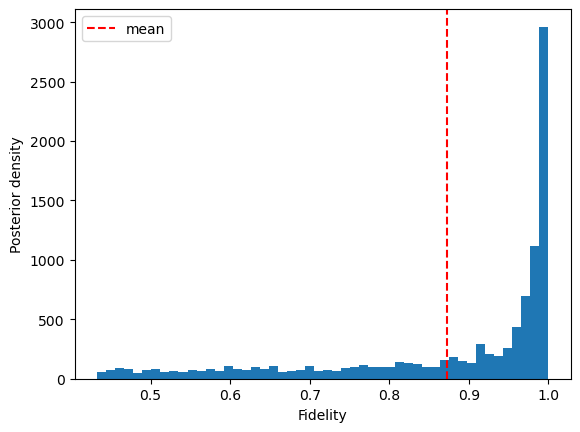

In [17]:

fidelities = np.zeros(samples.shape[0])
for i in range(samples.shape[0]):
    rho_sample = model.params_to_rho(samples[i])
    fidelities[i] = fidelity(rho_sample, rho_map)

mean = np.mean(fidelities)
plt.axvline(mean, color="r", linestyle="--", label="mean")

plt.hist(fidelities, bins=50)
plt.xlabel("Fidelity")
plt.ylabel("Posterior density")
plt.legend()
plt.show()

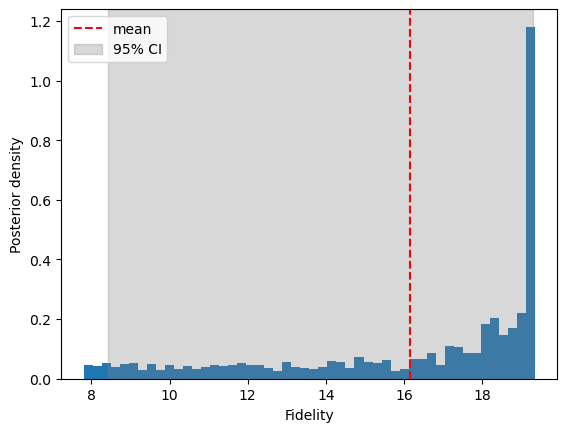

In [ ]:
fidelities = [np.real(np.trace(np.sqrt(np.sqrt(y_01[0]) @ rho @ np.sqrt(y_01[0])))**2)
              for rho in (model.params_to_rho(s) for s in samples)]

mean = np.mean(fidelities)
low, high = np.percentile(fidelities, [2.5, 97.5])

plt.hist(fidelities, bins=50, density=True)
plt.axvline(mean, color="r", linestyle="--", label="mean")
plt.axvspan(low, high, color="gray", alpha=0.3, label="95% CI")

